# Calibrazione definitivo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, SecondLocator, DateFormatter
import pandas as pd
from scipy.stats import linregress
from scipy.stats import chisquare
from scipy import stats
import math

In [2]:
# file necessari 

files_calibrazione_amb = np.array(['ambiente/dati/cal_g5_z6877_amb.txt', 'ambiente/dati/Cal_G5_Z8900_amb.txt', 'ambiente/dati/Cal_G5_z10923_amb.txt'])
parabola = pd.read_csv('dati/TDA2023_04_18.txt' , sep=';', header=None, comment = '#')

files_calibrazione_n = np.array(['azoto/dati/Cal_g5_z2832_az.txt', 'azoto/dati/Cal_g5_z4450_az.txt', 'azoto/dati/Cal_g5_z4854_az.txt', 'azoto/dati/cal_z5_z6877_az.txt'])

In [3]:
# valori zero_base

zero_base_amb = np.array([6877, 8900, 10923])
zero_base_n = np.array([2832, 4450, 4854, 6877])

## Ambiente

            rad      errore
0  15372.338802   34.663064
1   8385.746711  115.027222
2   1355.633663   26.759570


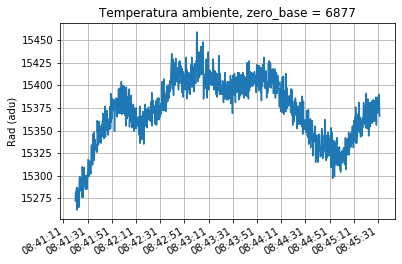

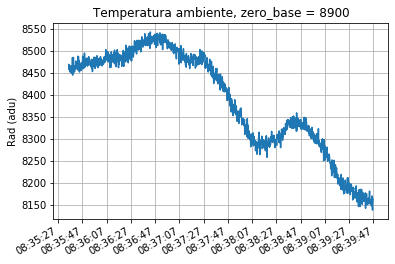

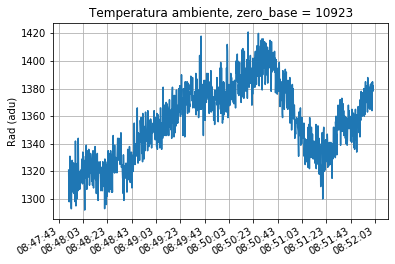

In [4]:
rad_amb = []

for i in range(0,3):
    calibrazione_1 = pd.read_csv (files_calibrazione_amb[i],
                                    sep = ' ',
                                    header=None,
                                    skiprows=10,
                                    decimal='.',
                                    names=['data','ora','rad','temperatura'])
    
    calibrazione_1['data_ora'] = calibrazione_1['data'].map(str) + ' ' + calibrazione_1['ora'].map(str)
    calibrazione_1['data_ora'] = pd.to_datetime(calibrazione_1['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
    calibrazione_1 = calibrazione_1.iloc[:,[-1,2,3]]
    
    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(calibrazione_1['data_ora'],calibrazione_1['rad'], label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(SecondLocator(interval = 20))

    plt.title('Temperatura ambiente, zero_base = ' + str(zero_base_amb[i]))
    plt.ylabel('Rad (adu)')
    plt.grid()

    plt.savefig('grafico_' + str(i+1))

    rad_amb.append([calibrazione_1.rad.mean(), math.sqrt(calibrazione_1.rad.std()**2 + 1)])  # deviazione standard della media? errori diventano piccolissimi

rad_amb = pd.DataFrame(rad_amb, columns=['rad', 'errore'])
print(rad_amb)

### Ricavo temperatura ambiente

In [5]:
parabola.rename(columns={0: 'day', 1: 'month', 2: 'year', 3:'hour', 4: 'minute', 5:'second', 45: 'T_1', 46: 'T_2', 47: 'T_3', 48: 'T_4'}, inplace = True)
parabola['data_ora'] = pd.to_datetime(parabola[['day','month','year','hour','minute','second']])
parabola = parabola.loc[:, ['data_ora','T_1','T_2','T_3','T_4']]

In [6]:
mask_1 = parabola.data_ora >= '2023-04-18 08:54:00'
mask_2 = parabola.data_ora <= '2023-04-18 09:11:00'

parabola = parabola.loc[mask_1 & mask_2]

In [7]:
# media sensori in celsius
temp_amb = [[parabola.T_1.mean(), math.sqrt(parabola.T_1.std()**2 + 0.1**2 + 0.5**2)],      # deviazione standard 
            [parabola.T_2.mean(), math.sqrt(parabola.T_2.std()**2 + 0.1**2 + 0.5**2)], 
            [parabola.T_3.mean(), math.sqrt(parabola.T_3.std()**2 + 0.1**2 + 0.5**2)]]
temp_amb = pd.DataFrame(temp_amb, columns=['temperatura', 'errore'])

# media sensori in kelvin
temp_amb['temperatura'] = [valore + 273.15 for valore in temp_amb['temperatura']]

In [8]:
# Calcolo media pesata della temperatura ambiente ed errore media

media_t_amb = temp_amb.temperatura.mean()
media_t_amb_err = math.sqrt(np.sum(temp_amb['errore']**2))


In [9]:
print('La temperatura ambiente media vale', media_t_amb, '+/-', media_t_amb_err)

La temperatura ambiente media vale 293.673431372549 +/- 1.1216665964075254


### Calibrazione ambiente

Text(0.5, 0, 'Zero_base')

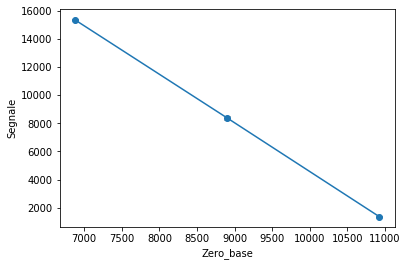

In [10]:
plt.errorbar(zero_base_amb, rad_amb['rad'], yerr= rad_amb['errore'], fmt='o-', ecolor='black', capsize=3, capthick=0.5)
plt.ylabel('Segnale') 
plt.xlabel('Zero_base')

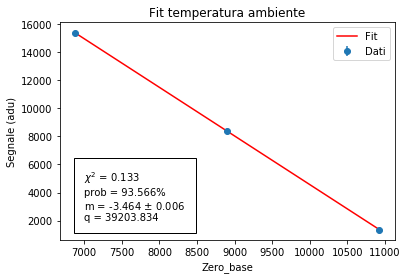

In [13]:
amb = linregress(zero_base_amb,rad_amb['rad']) #x and y are arrays or lists.

chi2 = round(np.sum (((rad_amb['rad'] - amb.intercept - amb.slope*(zero_base_amb))/(rad_amb['errore']))**2),3)

prob = round(stats.chi2.sf(chi2, 2) * 100, 3)  # calcolo probabilità chi quadro

plt.errorbar(zero_base_amb, rad_amb['rad'], yerr= rad_amb['errore'], fmt='o', label='Dati')
plt.plot(zero_base_amb, amb.intercept + amb.slope*(zero_base_amb), 'r-', label='Fit')

chi = '$\chi^2$ = ' + str(chi2) + '\n'
probab = 'prob = ' + str(prob) + '% \n' 
slope = 'm = ' + str(round(amb.slope, 3)) + ' $\pm$ ' + str(round(amb.stderr,3)) + '\n' # errore 0.3 con variazione chi
intercept = 'q = ' + str(round(amb.intercept, 3)) ## + ' $\pm$ ' + str(round(amb.intercept_stderr, 3))

plt.text(7000, 2000, chi + probab + slope + intercept, fontsize=10, bbox ={'facecolor':'white', 'pad':10},  color='black')
plt.legend()
plt.ylabel('Segnale (adu)')
plt.xlabel('Zero_base')
plt.title('Fit temperatura ambiente')
plt.show()

## Azoto

            rad     errore
0  16228.785655  33.820999
1  10568.148370  43.650645
2   9189.425021  37.754592
3   1870.828407  33.879580


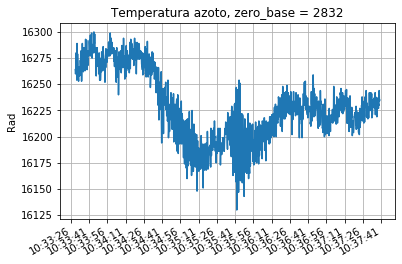

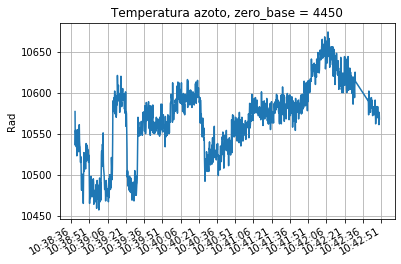

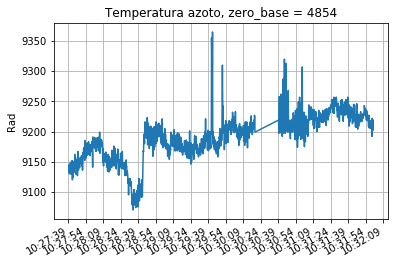

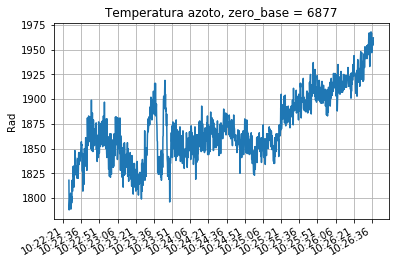

In [14]:
rad_n = []

for i in range(0,4):
    calibrazione_2 = pd.read_csv (files_calibrazione_n[i],
                                    sep = ' ',
                                    header=None,
                                    skiprows=10,
                                    decimal='.',
                                    names=['data','ora','rad','temperatura'])
    
    calibrazione_2['data_ora'] = calibrazione_2['data'].map(str) + ' ' + calibrazione_2['ora'].map(str)
    calibrazione_2['data_ora'] = pd.to_datetime(calibrazione_2['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
    calibrazione_2 = calibrazione_2.iloc[:,[-1,2,3]]

    if i == 1:
        mask_5 = calibrazione_2.data_ora <= '2023-04-18 10:42:30'
        mask_6 = calibrazione_2.data_ora >= '2023-04-18 10:42:40'

        calibrazione_2 = calibrazione_2[mask_5 | mask_6]

    if i == 2: 
        mask_3 = calibrazione_2.data_ora <= '2023-04-18 10:30:19'
        mask_4 = calibrazione_2.data_ora >= '2023-04-18 10:30:39'

        calibrazione_2 = calibrazione_2[mask_3 | mask_4]
    
    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(calibrazione_2['data_ora'],calibrazione_2['rad'],  label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(SecondLocator(interval = 15))

    plt.title('Temperatura azoto, zero_base = ' + str(zero_base_n[i]))
    plt.grid()
    plt.ylabel('Rad')

    plt.savefig('grafico_n_' + str(i+1))
    
    rad_n.append([calibrazione_2.rad.mean(), math.sqrt(calibrazione_2.rad.std()**2 + 1)])
    
rad_n = pd.DataFrame(rad_n, columns= ['rad', 'errore'])
print(rad_n)


### Calibrazione azoto

Text(0.5, 0, 'Zero_base')

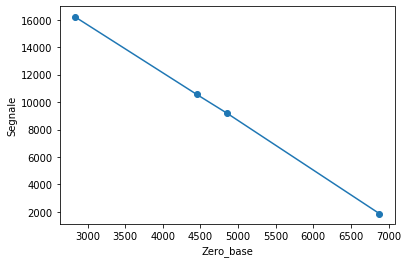

In [15]:
plt.errorbar(zero_base_n, rad_n['rad'], yerr= rad_n['errore'], fmt='o-')
plt.ylabel('Segnale')
plt.xlabel('Zero_base')

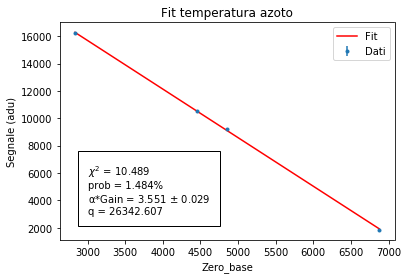

In [17]:
azoto = linregress(zero_base_n,rad_n['rad'])

chi2 = round(np.sum (((rad_n['rad'] - azoto.intercept - azoto.slope*(zero_base_n))/(rad_n['errore']))**2),3)
prob = round(stats.chi2.sf(chi2, 3) * 100, 3)  # calcolo probabilità chi quadro

plt.errorbar(zero_base_n, rad_n['rad'], yerr=rad_n['errore'], fmt='.', label='Dati')
plt.plot(zero_base_n, azoto.intercept + azoto.slope*(zero_base_n), 'r-', label='Fit')

chi = '$\chi^2$ = ' + str(chi2) + '\n'
probab = 'prob = ' + str(prob) + '% \n' 
slope = '\u03B1*Gain = ' + str(-round(azoto.slope, 3)) + ' $\pm$ ' + str(round(azoto.stderr,3)) + '\n'
intercept = 'q = ' + str(round(azoto.intercept, 3)) ## + ' $\pm$ ' + str(round(azoto.intercept_stderr, 3))
plt.text(3000, 3000, chi + probab + slope + intercept, fontsize=10, bbox ={'facecolor':'white', 'pad':10},  color='black')

plt.title('Fit temperatura azoto')
plt.ylabel('Segnale (adu)')
plt.xlabel('Zero_base')
plt.legend()
plt.show()

## Ricavo gamma

In [18]:
temp_azoto = 77.36 
temp_azoto_err = 0.22

print(media_t_amb)
print(temp_azoto)

293.673431372549
77.36


In [20]:
# prodotto alpha per Gain(5)
alpha_gain = [[-azoto.slope, 0.024],[-amb.slope, 0.03]]
alpha_gain = pd.DataFrame(alpha_gain, columns= ['misura', 'errore'])
# alpha_gain['peso'] = 1/(alpha_gain.errore)**2
print(alpha_gain)

# alpha_g = (np.sum(alpha_gain.peso * alpha_gain.alpha_gain))/(np.sum(alpha_gain.peso))  # media alpha * gain
# alpha_g_err = 1 / math.sqrt(np.sum(alpha_gain.peso))
# print('\u03B1*Gain vale', round(alpha_g,3))
# print("L'errore vale", round(alpha_g_err,3))

alpha_g = np.mean(alpha_gain.misura)
alpha_g_err = math.sqrt(np.sum(alpha_gain.errore)**2)


print('\u03B1*Gain vale', round(alpha_g,4))
print("L'errore vale", round(alpha_g_err,3))

     misura  errore
0  3.550899   0.024
1  3.464336   0.030
α*Gain vale 3.5076
L'errore vale 0.054


In [35]:
num = (amb.intercept - azoto.intercept)
print(num)
den = (media_t_amb - temp_azoto)
print(den)

errore_num = math.sqrt((amb.intercept_stderr**2) + (azoto.intercept_stderr**2)) # errore num
errore_den = math.sqrt((media_t_amb_err)**2 + (temp_azoto_err)**2)  # errore den

gamma = num/(84*den)
errore_gamma = (math.sqrt((errore_num/num)**2 + (errore_den/den)**2) * gamma)/84
print('gamma vale', gamma)
print('errore gamma vale', errore_gamma)

12861.226801370496
216.3125311389225
gamma vale 0.7078177212725899
errore gamma vale 0.00010173582145411878


## ricavo t_r

In [22]:
a = rad_amb['rad'] - amb.slope*zero_base_amb
b = 84*gamma
c = media_t_amb

# t_r_amb = [(rad_amb['rad'] - amb.slope*zero_base_amb)/(84*gamma) - media_t_amb]
tr_amb = a/b - c

errore_c = media_t_amb_err
print(errore_c)

errore_b = 84*errore_gamma

# errore_a = 


# errore temperatura riferimento è la radice dell'errore di 1 al quadrato + l'errore della media della temperatura ambiente al quadrato
# errore 1: 1 * ((errore num / num)^2 + (errore den / den)^2 )
# errore den: 84 per errore gamma

# den_1 = 84*gamma
# errore_den_1 = 84 * errore_gamma
# print(den_1, errore_den_1)

# num_1 = rad_amb['rad'] - amb.slope*zero_base_amb
# errore_num_1_2 = (np.array(rad_amb['errore']**2) + (zero_base_amb*amb.stderr)**2)

# errore num: sqrt di errore_rad^2 + errore 2^2
# errore 2: zero_base * errore amb.slope

# errore_2 = zero_base_amb * amb.stderr

0.37381002369998406


In [19]:
np.array(rad_amb['errore']**2) + (zero_base_amb*amb.stderr)**2

array([ 3024.51556215, 16285.20986249,  5316.66223482])

In [ ]:
t_r_n = np.array((rad_n['rad'] - azoto.slope*zero_base_n)/(84*gamma) - temp_azoto)

print(t_r_n)

t_rif = sum(t_r_n)/4 

print('Media della temperatura di riferimento:', t_rif)

[364.72224901 366.14709338 367.08625452 364.81355472]
Media della temperatura di riferimento: 365.69228790658553


In [ ]:
t_r_n

array([364.72224901, 366.14709338, 367.08625452, 364.81355472])